In [1]:
#Primero importamos algunas librerias
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
from matplotlib import colors
import matplotlib.patches as mpatches
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
import os

In [2]:
ee.Authenticate()
# ee.Initialize(project='ee-ccamz2')
ee.Initialize(project='ee-tomasromero')

In [3]:
# Seleccionamos rango de fechas
startDate= '2012-01-01'
endDate = '2012-1-31'

# Observatorios

Cargamos el mapa de Chile, seleccionamos las regiones que nos interesan, y eliminamos las islas del mapa

In [4]:
chile = gpd.read_file('Datos/Regiones/Regional.shp').to_crs(epsg=4326).to_crs(epsg=32719)
chile = chile[chile['codregion'].isin([2, 3, 4, 5, 13])]

In [5]:
#Funcion dada por chatGpt para eliminar las islas y podamos plotear correctamente Chile continental
def keep_only_mainland(geom):
    if geom.geom_type == 'Polygon':
        return geom
    elif geom.geom_type == 'MultiPolygon':
        # Se queda con el polígono de mayor área
        largest = max(geom.geoms, key=lambda g: g.area)
        return largest
    else:
        return geom

In [6]:
# Aplicar a todas las geometrías
chile['geometry'] = chile['geometry'].apply(keep_only_mainland)

Cargamos los observatorios en Chile

In [7]:
obs = gpd.read_file('Datos/observatorios_filtrados/observatorios_filtrados.shp')
obs

,Nombre,Altitud (m,Ubicación,Tipo,Estado,Año de In,Área Lent,geometry
0,ALMA,5000,"Llano de Chajnantor, Antofagasta",Radio,Operativo,2003,41001.06121734071,POINT (627616.73 7453491.29)
1,APEX,5100,"Llano de Chajnantor, Antofagasta",Radio,Operativo,2003,113.09733552923257,POINT (627765.499 7455317.008)
2,ACT,5190,"Cerro Toco, Antofagasta",Radio,Operativo,2007,28.274333882308134,POINT (624303.488 7460583.317)
3,Paranal (VLT),2635,"Cerro Paranal, Antofagasta",Óptico/Infrarrojo,Operativo,1991,211.23836840423655,POINT (357868.676 7275604.962)
4,ELT (en construcción),3046,"Cerro Armazones, Antofagasta",Óptico/Infrarrojo,En construcción,2014,1194.690595328151,POINT (379515.847 7279984.395)
5,La Silla,2400,"Cerro La Silla, Coquimbo",Óptico,Operativo,1964,10.179015632055895,POINT (331448.229 6762171.263)
6,Cerro Tololo (CTIO),2200,"Cerro Tololo, Coquimbo",Óptico,Operativo,1963,12.566370614359172,POINT (326087.737 6661087.851)
7,Gemini Sur,2737,"Cerro Pachón, Coquimbo",Óptico/Infrarrojo,Operativo,1994,51.51838900400386,POINT (332901.924 6653267.041)
8,Vera C. Rubin Observatory,2663,"Cerro Pachón, Coquimbo",Óptico,En construcción,2014,55.41985163906199,POINT (331695.656 6652838.358)
9,Magellan (Las Campanas),2400,"Cerro Las Campanas, Atacama",Óptico,Operativo,1999,66.46813142637272,POINT (335160.68 6789237.888)


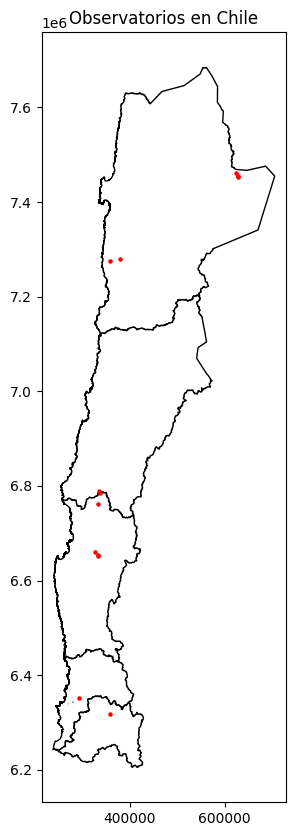

In [8]:
chile.to_crs(obs.crs, inplace=True)
chile.plot(color='white', edgecolor='black', figsize=(10, 10))
obs.plot(ax=plt.gca(), color='red', markersize=5)
plt.title('Observatorios en Chile')
plt.show()

## Contaminacion Luminica
[Nighttime Lights Time Series Version 4](https://developers.google.com/earth-engine/datasets/catalog/NOAA_DMSP-OLS_NIGHTTIME_LIGHTS?hl=es-419)

In [9]:
collection = (ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS").filterDate(startDate, endDate))

In [10]:
# Selecciona la imagen promedio del año
cL = collection.mean()

# Selecciona la banda de intensidad de luces nocturnas
cL = cL.select('stable_lights')

# Define parámetros de visualización
cL_vis_params = {
    'min': 0,
    'max': 63,
    'palette': ['000000', 'ffff00', 'ffffff']
}

In [11]:
# Crea un mapa interactivo
Map = geemap.Map(center=[20, 0], zoom=2)
Map.addLayer(cL, cL_vis_params, 'Luces nocturnas (promedio)')
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## Nubosidad
[Terra Atmosphere Monthly Global Product](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD08_M3?hl=es-419)

In [12]:
collection = (ee.ImageCollection("MODIS/061/MOD08_M3").filterDate(startDate, endDate))

## Elevacion
[NASA SRTM Digital Elevation 30m](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003?hl=es-419)

## Precipitacion
[TCHIRPS Daily: Climate Hazards Center InfraRed Precipitation](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY?hl=es-419)

## Calidad del aire
[Terra & Aqua MAIAC Land Aerosol Profundidad óptica Diario 1 km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES?hl=es-419)

## Gases Atmosfericos
[Sentinel-5P OFFL AER AI: Índice de Aerosol UV fuera de línea ](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_AER_AI?hl=es-419)

## Uso del Suelo
[ESA WorldCover 10m v100](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100?hl=es-419)

## Urbanizacion Historica
[Landsat 8-9](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=es-419)